In [ ]:
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
from dataclasses import dataclass

device = torch.device("cuda")

In [ ]:
model_id = 'bert-base-uncased'

bert = AutoModel.from_pretrained(model_id)
tokenizer = BertTokenizerFast.from_pretrained(model_id)

demo_text = ["How are you doing today?", "what do you do?"]
sent_id = tokenizer.batch_encode_plus(demo_text, padding=True)
print(f"demo_text encoded:{sent_id}\n")
print(f"demo_text encoding decoded: {tokenizer.batch_decode(sent_id['input_ids'])}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

demo_text encoded:{'input_ids': [[101, 2129, 2024, 2017, 2725, 2651, 1029, 102], [101, 2054, 2079, 2017, 2079, 1029, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 0]]}

demo_text encoding decoded: ['[CLS] how are you doing today? [SEP]', '[CLS] what do you do? [SEP] [PAD]']


In [ ]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
@dataclass
class Config:
    labels_yelp_p: int = 2
    labels_yelp_f: int = 5
    labels_imdb: int = 2

cfg = Config()
print(cfg)

Config(labels_yelp_p=2, labels_yelp_f=5, labels_imdb=2)


In [ ]:
class BertFineTune(nn.Module):
    def __init__(self, bert, config):
        super(BertFineTune, self).__init__()
        self.bert = bert

        self.yelp_p = nn.Linear(768, config.labels_yelp_p)
        self.yelp_f = nn.Linear(768, config.labels_yelp_f)
        self.imdb = nn.Linear(768, config.labels_imdb)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask, task):
        out = self.bert(sent_id, attention_mask=mask) # out.shape = batch x seq_length x model_dim
        # out.last_hidden_state give final hidds of [CLS] w1 w2 ... [SEP] etc. we want only hidd state of [CLS]
        hidd_embeds = out.last_hidden_state



        if task == "yelp_p":
            cls_hs = hidd_embeds[:,0,:]
            x = self.yelp_p(cls_hs)
            x = self.softmax(x)

        if task == "yelp_f":
            cls_hs = hidd_embeds[:,0,:]
            x = self.yelp_f(cls_hs)
            x = self.softmax(x)

        if task == "imdb":
            cls_hs = hidd_embeds[:,0,:]
            x = self.imdb(cls_hs)
            x = self.softmax(x)

        return x

model = BertFineTune(bert, cfg)
model = model.to(device)

In [ ]:
# Dataset Loading
from datasets import load_dataset

SEED = 42

DATASETS = ['stanfordnlp/imdb', 'yelp_review_full']

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Example text with label 0:
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes a

<Axes: >

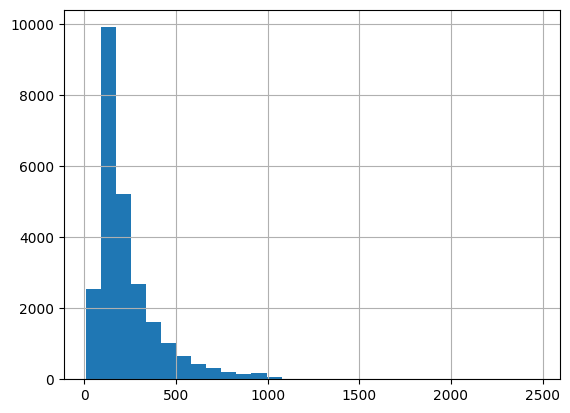

In [ ]:
dataset = load_dataset("stanfordnlp/imdb")
train_text, train_labels = dataset['train']['text'], dataset['train']['label']
test_text, test_labels = dataset['train']['text'], dataset['train']['label']

print(f"Example text with label {train_labels[0]}:\n{train_text[0]}")

# Input length histogram of the dataset
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
train_tokens = tokenizer.batch_encode_plus(
    (train_text),
    max_length = 300,
    pad_to_max_length=True,
    truncation = True
)

test_tokens = tokenizer.batch_encode_plus(
    (test_text),
    max_length = 300,
    pad_to_max_length=True,
    truncation = True
)

# (train_tokens)['input_ids']
train_seq = torch.tensor(train_tokens['input_ids'])
train_mask = torch.tensor(train_tokens['attention_mask'])
train_y = torch.tensor(train_labels)

test_seq = torch.tensor(test_tokens['input_ids'])
test_mask = torch.tensor(test_tokens['attention_mask'])
test_y = torch.tensor(test_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 512

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [ ]:
# Freeze BERT layers for discovering optimal parameters and methods before BERT is pre-trained too
for param in model.bert.parameters():
    param.requires_grad = False

In [ ]:
# for nm, param in model.(bert).named_parameters():
#     if nm.startswith("encoder.layer.11") or nm.startswith("pooler.dense"):
#         param.requires_grad = True

In [ ]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

6921

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:",class_weights)

Class Weights: [1. 1.]


In [ ]:
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights)

In [ ]:
import time

def train():
    model.train()

    total_loss, total_accuracy = 0, 0
    # total_preds=[]

    batches = len(train_dataloader)
    step_size = batches//10

    avg_loss = 0
    st = time.time()

    for step,batch in enumerate(train_dataloader):

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask, "imdb")
        loss = cross_entropy(preds, labels)

        total_loss = total_loss + loss.item()
        avg_loss += loss.item()
        if step % step_size == 0 and not step == 0:
            print(f' Batch: {step}/{batches}, | loss: {avg_loss/step_size:.4f} | Time : {time.time()-st}')
            st = time.time()
            avg_loss = 0

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        # preds=preds.detach().cpu().numpy()
        # total_preds.append(preds)


    avg_loss = total_loss / len(train_dataloader)
    # total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss #, total_preds.cpu().numpy()

In [ ]:
best_loss = float('inf')

train_losses=[]

SAVED_WEIGHTS_PATH = 'saved_weights.pt'
epochs = 3

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    train_loss = train()
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), SAVED_WEIGHTS_PATH)

    train_losses.append(train_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 3
 Batch: 4/49, | loss: 0.8567 | Time : 52.0309636592865
 Batch: 8/49, | loss: 0.6489 | Time : 40.032960176467896
 Batch: 12/49, | loss: 0.6197 | Time : 40.713639974594116
 Batch: 16/49, | loss: 0.5985 | Time : 40.4109992980957
 Batch: 20/49, | loss: 0.5738 | Time : 40.48482370376587
 Batch: 24/49, | loss: 0.5621 | Time : 40.535768270492554
 Batch: 28/49, | loss: 0.5427 | Time : 40.65366339683533
 Batch: 32/49, | loss: 0.5272 | Time : 40.63961172103882
 Batch: 36/49, | loss: 0.5099 | Time : 40.45732569694519
 Batch: 40/49, | loss: 0.4967 | Time : 40.4525671005249
 Batch: 44/49, | loss: 0.4834 | Time : 40.383124589920044
 Batch: 48/49, | loss: 0.4874 | Time : 38.310916900634766

Training Loss: 0.564

 Epoch 2 / 3
 Batch: 4/49, | loss: 0.5977 | Time : 51.082765102386475
 Batch: 8/49, | loss: 0.4688 | Time : 40.37424397468567
 Batch: 12/49, | loss: 0.4714 | Time : 40.73213839530945
 Batch: 16/49, | loss: 0.4523 | Time : 40.58065128326416
 Batch: 20/49, | loss: 0.4589 | Time : 

In [ ]:
model.load_state_dict(torch.load(SAVED_WEIGHTS_PATH))

<All keys matched successfully>

In [ ]:
test_data = TensorDataset(test_seq, test_mask, test_y)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

total_preds = []

for _, batch in enumerate(test_dataloader):
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
        preds = model(sent_id, mask, "imdb")

        # preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
total_preds  = np.concatenate(total_preds.detach().cpu().numpy(), axis=0)
preds = np.argmax(total_preds, axis = 1)
print(classification_report(test_y, preds))

AttributeError: 'list' object has no attribute 'detach'